<a href="https://colab.research.google.com/github/rohitr02/Fashion-Classification-Dataset-Analysis/blob/main/Fashion%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy.special import logsumexp  # to deal with potential overflow issues


def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

set_seed(42)

# Fashion MNIST

Download the Fashion MNIST dataset from [here](https://drive.google.com/drive/folders/1BnU7wVriolasZAZ1bSDTyll1Tp61hP1c?usp=sharing). It consists of 16 x 16 grayscale images (downsized from 28 x 28 for efficiency), split into 50,000 training and 10,000 validation images. Each image is labeled as one of 10 clothing categories (e.g., dress, sandal, shirt). We will assume that we have the directory `data/FashionMNIST/` in our Google Drive account. Let's load the data and stare at it.  

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datadir = '/content/drive/My Drive/data/FashionMNIST/'
label_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']  # Hardcoded

class FashionMNIST:

  def __init__(self, split):
    assert split in ['Tr', 'Vl']  # We don't have a test set
    self.inputs = np.load('{:s}x{:s}.npy'.format(datadir, split))  # (N, 16^2)
    self.labels = np.load('{:s}y{:s}.npy'.format(datadir, split))  # (N, 10)
    self.num_examples, self.dim = self.inputs.shape
    self.num_labels = self.labels.shape[1]

    # Partition data by labels
    self.partition = [self.inputs[np.where(np.argmax(self.labels, axis=1) == y)[0]] for y in range(self.num_labels)]

In [ ]:
data_train = FashionMNIST('Tr')
data_val = FashionMNIST('Vl')

print(data_train.inputs.shape, data_val.inputs.shape)

(50000, 256) (10000, 256)


In [ ]:
def show_image(image, ax=None):
  width = int(np.sqrt(image.shape[0]))
  image = image.reshape(width, width)  
  if ax == None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
  imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
  imgplot.set_interpolation('nearest')
  ax.xaxis.set_ticks_position('top')
  ax.yaxis.set_ticks_position('left')
  plt.axis('off')

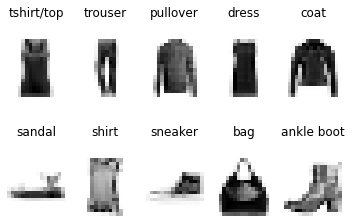

In [ ]:
for y in range(10):
  ax = plt.subplot(2, 5, y + 1)
  ax.clear()
  show_image(data_train.partition[y][0], ax)
  ax.set_title(label_names[y])

The images are a little blurry because we downsized them, but they will do. 

# Gaussian Mixture Model (GMM)

A **Gaussian mixture model** (GMM) with $K$ components has learnable parameters $\pi \in \mathbb{R}^K$ and $\mu_k \in \mathbb{R}^K, \Sigma_k \in \mathbb{R}^{K \times K}$ for each $k = 1 \ldots K$, where it is always assumed that 

- $\pi$ is a (full-support) distribution over the $K$ components. So $\pi_k > 0$ and $\sum_{k=1}^K \pi_k = 1$. 
- $\Sigma_k$ is a symmetric and positive definite (thus invertible) for each $k$. 

A GMM  defines a joint distribution over $k \in \{1 \ldots K\}$ and $x \in \mathbb{R}^d$ by 
$$
p(k,x) = \pi_k \times \mathcal{N}(\mu_k, \Sigma_k)(x)
$$
where $\mathcal{N}(\mu_k, \Sigma_k)(x)$ is the probability of $x$ under the Gaussian distribution with mean $\mu_k$ and covariance matrix $\Sigma_k$. For practical reasons, we do the following:  

- We optionally restrict ourselves to *diagonal* covariance matrices to make calculation simpler and more efficient.
- We work in *log space* for numerical stability, that is: $\log p(k,x) = \log \pi_k + \log \mathcal{N}(\mu_k, \Sigma_k)(x)$. 
- We make all variables multidimensional tensors so that we can use linear algebraic operations instead of for loops. 

In [ ]:
import time
class GMM:

  def __init__(self, dim, num_components, diag=False):
    self.pi = np.full(num_components, 1. / num_components)  # (K,)
    self.mu = np.zeros((num_components, dim))  # (K, d)
    if diag:
      self.sigma = np.ones((num_components, dim))  # (K, d)
    else:   
      self.sigma = np.array([np.identity(dim) for _ in range(num_components)])   # (K, d, d)
    self.diag = diag

  def compute_log_probs(self, inputs):  # (N, d)
    log_pi = np.log(self.pi)[:, np.newaxis]  # (K, 1)
    diffs = inputs[np.newaxis, :, :] - self.mu[:, np.newaxis, :]  # (K, N, d)

    # TODO: implement, do not use for loops
    if self.diag:
      log_frac = (-1/2)*(inputs.shape[1]*np.log(2*math.pi) + np.sum(np.log(self.sigma),axis=1))
      residual = (-1/2)*np.einsum('ij,ikj->ik', np.reciprocal(self.sigma), np.square(diffs))
    else:
      log_frac = (-1/2)*(inputs.shape[1]*np.log(2*math.pi) + np.linalg.slogdet(self.sigma)[1])
      residual = (-1/2)*np.einsum('ijk,ikj->ij', diffs, np.linalg.inv(self.sigma)@np.transpose(diffs, (0,2,1)))

    log_probs = np.transpose(np.array([(log_pi.squeeze() + log_frac)] * len(inputs))) + residual
    return log_probs

  def compute_posteriors(self, inputs):  # (N, d)
    log_probs = self.compute_log_probs(inputs)  # (K, N): log p(k, x)
    marginal_log_probs = logsumexp(log_probs, axis=0)  # (N,): log p(x)
    marginal_log_likelihood = marginal_log_probs.mean()  # Scalar
    posteriors = np.exp(log_probs - marginal_log_probs[np.newaxis, :])  # (K, N): p(k|x)
    return posteriors, marginal_log_likelihood, marginal_log_probs

In [ ]:
import unittest

from scipy.stats import multivariate_normal 

class TestGMM(unittest.TestCase):
      
  def setUp(self):
    set_seed(42)
    self.dim = 100
    self.num_components = 7
    self.num_examples = 200
    self.power = 2 # Check for numerical stability

    self.inputs = np.random.randn(self.num_examples, self.dim)

  def test_model_diag(self): 
    model = self.init_model(diag=True)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def test_model_nondiag(self): 
    model = self.init_model(diag=False)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def get_log_probs_gold(self, model):
    log_probs_gold = []
    for k in range(self.num_components):
      dist = multivariate_normal(mean=model.mu[k], cov=(np.diag(model.sigma[k]) if model.diag else model.sigma[k]))
      log_probs_gold.append([np.log(model.pi[k]) + dist.logpdf(self.inputs[i]) for i in range(self.num_examples)])
    return np.array(log_probs_gold)

  def init_model(self, diag=False):
    model = GMM(self.dim, self.num_components, diag=diag)
    pi_unnormalized = np.random.uniform(size=(self.num_components,)) ** self.power
    model.pi = pi_unnormalized / pi_unnormalized.sum()
    model.mu = np.random.randn(self.num_components, self.dim) ** self.power 
    if diag:
      model.sigma = np.random.randn(self.num_components, self.dim) ** self.power
    else:
      model.sigma = np.array([np.diag(np.random.randn(self.dim)) ** self.power for _ in range(self.num_components)])
    return model
            
unittest.main(TestGMM(), argv=[''], verbosity=2, exit=False)

test_model_diag (__main__.TestGMM) ... ok
test_model_nondiag (__main__.TestGMM) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.325s

OK


# Expectation Maximization (EM)

The EM algorithm trains a GMM on *unlabeled* data by alternating the E step and the M step:
- E step: Compute posteriors $p(k|x_i)$ for every training input $i = 1 \ldots N$ and label $k = 1\ldots K$. This needs an initial set of parameter values.
- M step: Calculate the maximum-likelihood estimate of parameters under the posteriors.


In [ ]:
class GMMTrainerEM:

  def __init__(self, model, smoothing=0.1):
    self.model = model
    self.smoothing = smoothing
    self.diag_smoother =  smoothing * np.array([np.identity(model.mu.shape[1]) for _ in range(model.mu.shape[0])])

  def train(self, inputs, num_iterations_max=40, verbose=False, init_method='naive'):
    self.init_centers(inputs, init_method=init_method)
    mll_previous = -np.inf 
    posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
    for iteration in range(num_iterations_max): 
      self.update_parameters(inputs, posteriors)  # M step
      posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
      if verbose:
        print('Iteration {:3d}:\t marginal log-likelihood {:10.4f}'.format(iteration + 1,  mll))
      if np.isclose(mll, mll_previous):
        break
      mll_previous = mll
    return mll, iteration

  def update_parameters(self, inputs, posteriors):
    expected_counts = posteriors.sum(axis=1) + self.smoothing # (K,)
    self.model.pi = expected_counts / expected_counts.sum()

    weighted_sums = posteriors @ inputs  # (K, d)
    self.model.mu = weighted_sums / expected_counts[:, np.newaxis]

    diffs = inputs[np.newaxis, :, :] - self.model.mu[:, np.newaxis, :]  # (K, N, d)
    diffs_weighted = posteriors[:, :, np.newaxis] * diffs  # (K, N, d)

    # TODO: Implement
    if self.model.diag:
      sig_num = np.einsum('ijj->ij', np.transpose(diffs_weighted, (0,2,1))@diffs)
      self.model.sigma = sig_num/expected_counts[:, np.newaxis] + np.einsum('ijj->ij', self.diag_smoother)
    else:
      self.model.sigma = np.transpose(diffs_weighted, (0,2,1))@diffs/(expected_counts[:, np.newaxis])[:,None] + self.diag_smoother
    
  def init_centers(self, inputs, init_method='naive'):
    # Find K centers from the given input vectors (N, d) somehow.
    if init_method == 'naive':

      # TODO: Implement. Tip: try selecting a random input as the first center, then iteratively selecting argmax_i sum_{l<k} ||x_l - x_i||
      self.model.mu = np.array([inputs[random.randint(0, len(inputs)-1)]])
      for k in np.arange(1, len(self.model.pi)):
        norm = np.linalg.norm(self.model.mu - inputs[:, np.newaxis], axis=2)
        update_mu = inputs[np.argmax(np.sum(norm, axis=1))]
        self.model.mu = np.concatenate((self.model.mu, np.array([update_mu])), axis=0)

    else: 
      raise ValueError('Unknown init method: ' + init_method)

# Experiments with Diagonal GMMs

We can use GMMs for classification, by training a GMM for each input partition with the same label then at test time predicting the label corresponding to the GMM with highest *marginal* likelihood.

In [ ]:
def compute_accuracy(models, data):  # models[y]: GMM for label y
  log_probs_all = np.zeros((data.num_examples, data.num_labels))
  for y in range(data.num_labels):
    log_probs_all[:, y] = logsumexp(models[y].compute_log_probs(data.inputs), axis=0)  # TODO: Implement
  preds = np.argmax(log_probs_all, axis=1)
  acc = np.mean(preds == np.argmax(data.labels, axis=1)) * 100.
  return acc, preds

One cool thing is that each mean $\mu_k$ corresponding to component $k$ can be visualized. We will hypothesize that different components learn different representations of the same label.

In [ ]:
def show_means(models, y):
  num_components = len(models[y].pi)
  fig, axes = plt.subplots(1, num_components)

  for k in range(num_components):
    if num_components == 1:
      ax = axes
    else:
      ax = axes[k]
    show_image(models[y].mu[k], ax)
    ax.axis("off")
    if k == 0:
      ax.set_title(label_names[y] + "/" + str(k))
    else:
      ax.set_title("/" + str(k))
  return fig, axes

We're ready to train diagonal GMMs with various $K$ values. The training is pretty sensitive to the smoothing parameter so be careful. 

***Training a diagonal GMM with K=1 components***
Label 0:  1 iterations, final MLL    -18.360
Label 1:  1 iterations, final MLL     13.110
Label 2:  1 iterations, final MLL    -27.079
Label 3:  1 iterations, final MLL     -3.922
Label 4:  1 iterations, final MLL    -16.957
Label 5:  1 iterations, final MLL    -10.366
Label 6:  1 iterations, final MLL    -30.040
Label 7:  1 iterations, final MLL     15.278
Label 8:  1 iterations, final MLL    -48.372
Label 9:  1 iterations, final MLL    -13.003
K=1: acc train 65.01, acc val 64.29


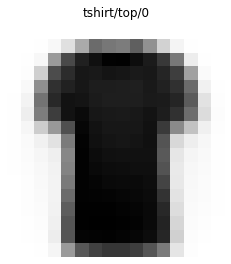

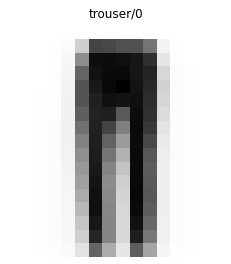

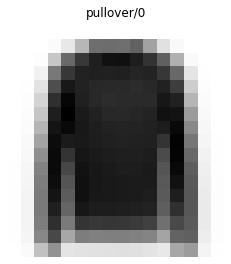

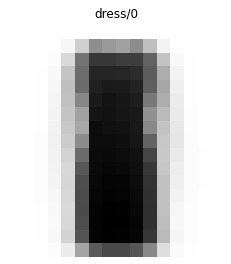

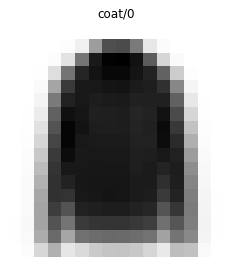

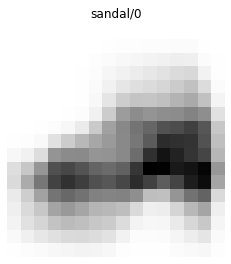

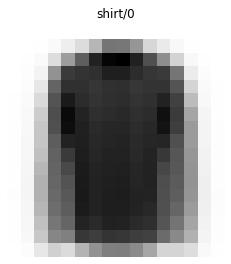

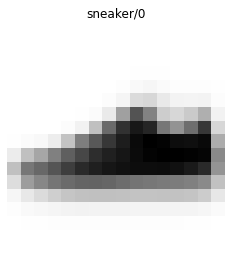

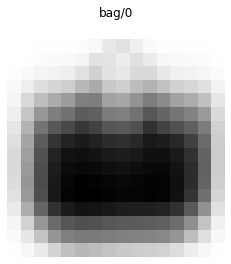

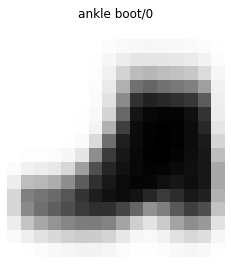

***Training a diagonal GMM with K=3 components***
Label 0: 16 iterations, final MLL      6.976
Label 1: 18 iterations, final MLL     24.300
Label 2: 30 iterations, final MLL      4.003
Label 3: 29 iterations, final MLL     13.942
Label 4: 14 iterations, final MLL      7.669
Label 5: 39 iterations, final MLL      2.003
Label 6: 19 iterations, final MLL      2.574
Label 7: 39 iterations, final MLL     25.045
Label 8: 17 iterations, final MLL    -17.719
Label 9: 28 iterations, final MLL      7.215
K=3: acc train 72.85, acc val 72.48


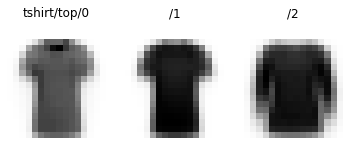

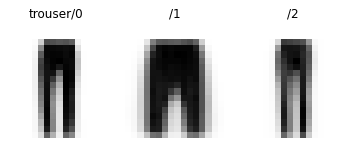

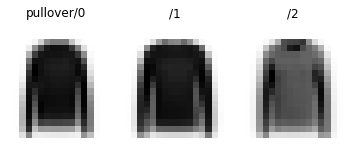

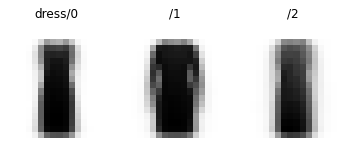

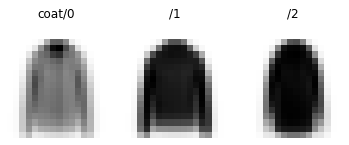

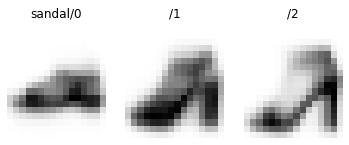

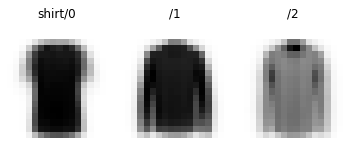

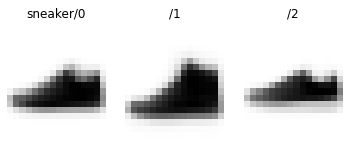

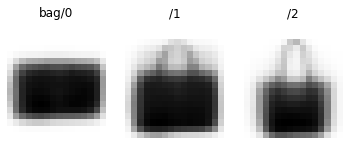

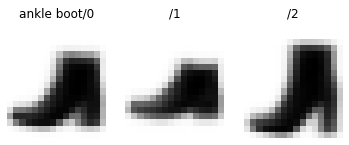

***Training a diagonal GMM with K=5 components***
Label 0: 31 iterations, final MLL     11.151
Label 1: 17 iterations, final MLL     28.549
Label 2: 39 iterations, final MLL     10.091
Label 3: 36 iterations, final MLL     17.483
Label 4: 32 iterations, final MLL     13.676
Label 5: 37 iterations, final MLL      5.854
Label 6: 39 iterations, final MLL      9.186
Label 7: 39 iterations, final MLL     28.812
Label 8: 39 iterations, final MLL     -6.830
Label 9: 39 iterations, final MLL     11.730
K=5: acc train 71.09, acc val 70.12


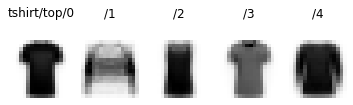

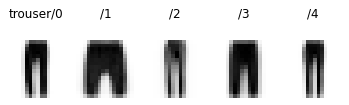

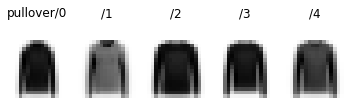

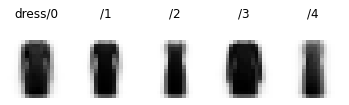

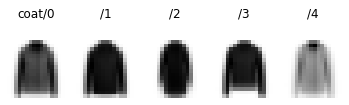

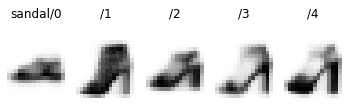

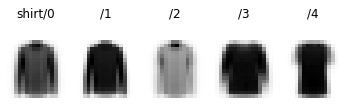

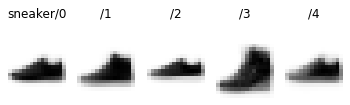

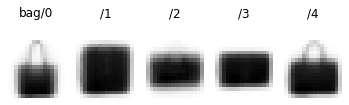

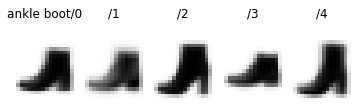

***Training a diagonal GMM with K=7 components***
Label 0: 13 iterations, final MLL     11.956
Label 1: 39 iterations, final MLL     29.655
Label 2: 39 iterations, final MLL     13.116
Label 3: 39 iterations, final MLL     19.548
Label 4: 39 iterations, final MLL     16.517
Label 5: 33 iterations, final MLL      7.769
Label 6: 39 iterations, final MLL      9.944
Label 7: 15 iterations, final MLL     29.863
Label 8: 39 iterations, final MLL     -4.205
Label 9: 39 iterations, final MLL     14.255
K=7: acc train 73.22, acc val 72.27


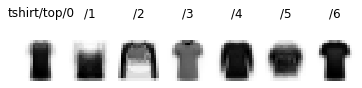

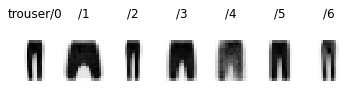

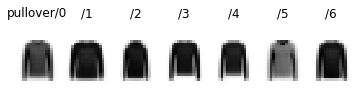

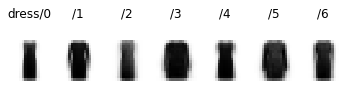

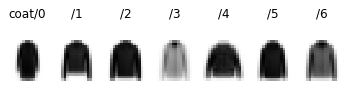

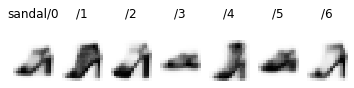

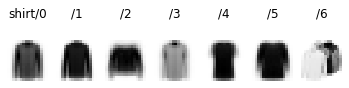

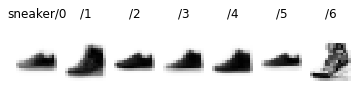

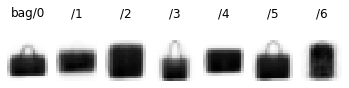

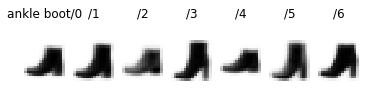

***Training a diagonal GMM with K=9 components***
Label 0: 24 iterations, final MLL     15.641
Label 1: 25 iterations, final MLL     31.146
Label 2: 39 iterations, final MLL     14.466
Label 3: 35 iterations, final MLL     20.484
Label 4: 20 iterations, final MLL     17.915
Label 5: 39 iterations, final MLL      9.095
Label 6: 22 iterations, final MLL     13.266
Label 7: 14 iterations, final MLL     30.884
Label 8: 39 iterations, final MLL     -1.229
Label 9: 20 iterations, final MLL     17.141
K=9: acc train 74.35, acc val 73.59


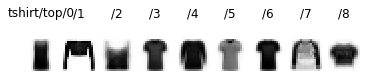

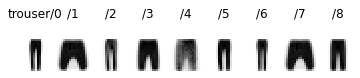

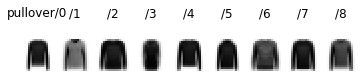

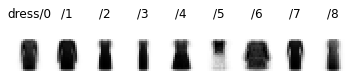

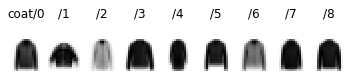

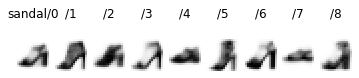

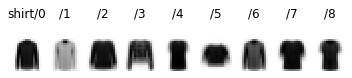

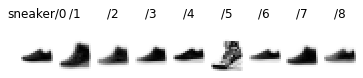

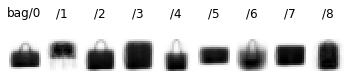

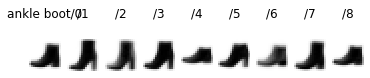

***Training a diagonal GMM with K=11 components***
Label 0: 25 iterations, final MLL     16.442
Label 1: 39 iterations, final MLL     30.445
Label 2: 39 iterations, final MLL     15.981
Label 3: 28 iterations, final MLL     22.241
Label 4: 19 iterations, final MLL     18.685
Label 5: 37 iterations, final MLL      9.641
Label 6: 39 iterations, final MLL     14.212
Label 7: 32 iterations, final MLL     31.441
Label 8: 39 iterations, final MLL      1.793
Label 9: 39 iterations, final MLL     18.274
K=11: acc train 75.12, acc val 74.20


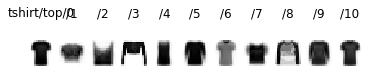

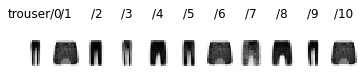

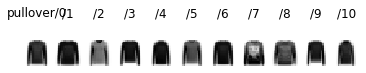

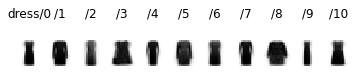

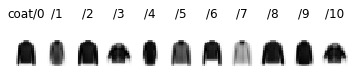

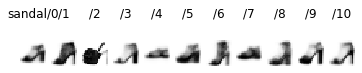

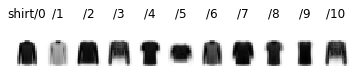

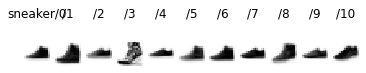

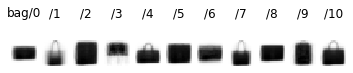

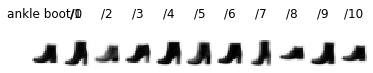

***Training a diagonal GMM with K=13 components***
Label 0: 25 iterations, final MLL     16.801
Label 1: 27 iterations, final MLL     31.707
Label 2: 39 iterations, final MLL     16.937
Label 3: 39 iterations, final MLL     22.860
Label 4: 36 iterations, final MLL     20.958
Label 5: 39 iterations, final MLL     10.742
Label 6: 39 iterations, final MLL     15.551
Label 7: 15 iterations, final MLL     31.169
Label 8: 39 iterations, final MLL      3.390
Label 9:  9 iterations, final MLL     18.457
K=13: acc train 76.21, acc val 74.72


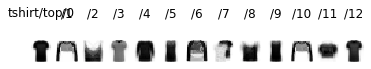

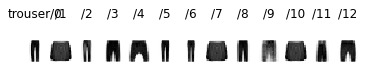

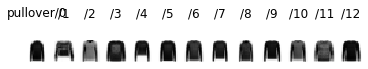

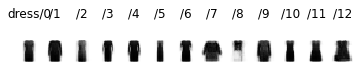

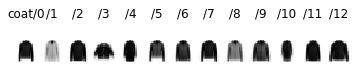

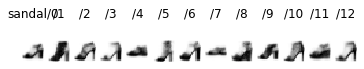

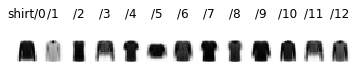

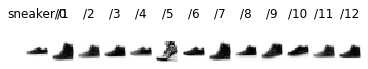

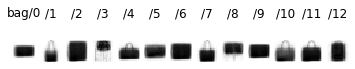

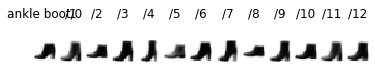

In [ ]:
set_seed(0)
smoothing = 0.1

for num_components in [1, 3, 5, 7, 9, 11, 13]:
  print('***Training a diagonal GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=True)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))
  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()

## <font color=red>Question</font>
For GMMs with diagonal covariance matrices, report
- $K=1$: train acc, val acc
- $K=3$: train acc, val acc

## <font color=red>Answer</font>
- $K=1$: the train acc is 65.01 and the val acc is 64.29

- $K=3$: the train acc is 72.85 and the val acc is 72.48

# Experiments with Full-Covariance GMMs

Similarly we will train full-covariance GMMs for various $K$ values. Again, the training is pretty sensitive to the smoothing parameter. In fact, the marginal log-likelihood may take positive values (invalid!!!) due to numerical instability, but we can still do classification with the model.

***Training a full-covariance GMM with K=1 components***
Label 0:  1 iterations, final MLL    351.134
Label 1:  1 iterations, final MLL    470.375
Label 2:  1 iterations, final MLL    368.576
Label 3:  1 iterations, final MLL    384.042
Label 4:  1 iterations, final MLL    377.258
Label 5:  1 iterations, final MLL    313.707
Label 6:  1 iterations, final MLL    328.058
Label 7:  1 iterations, final MLL    438.907
Label 8:  1 iterations, final MLL    264.302
Label 9:  1 iterations, final MLL    349.155
K=1: acc train 76.28, acc val 74.05


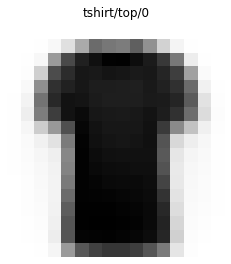

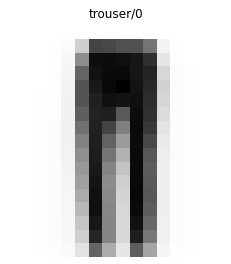

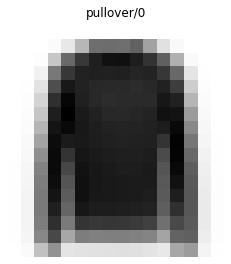

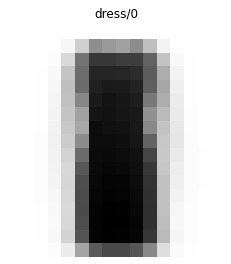

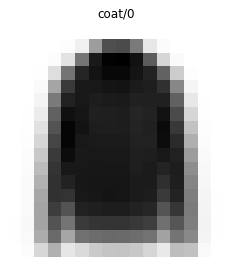

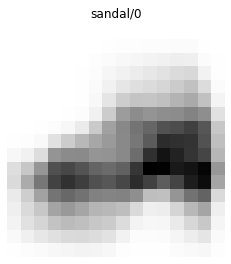

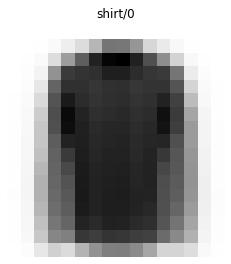

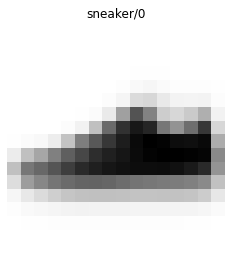

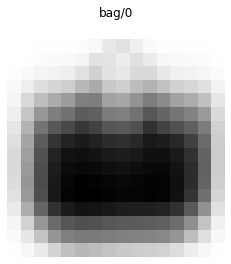

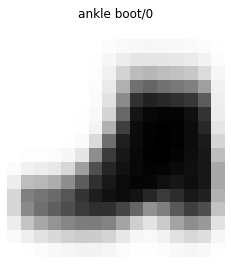

***Training a full-covariance GMM with K=3 components***
Label 0: 15 iterations, final MLL    379.567
Label 1: 36 iterations, final MLL    501.726
Label 2: 15 iterations, final MLL    409.647
Label 3: 23 iterations, final MLL    422.260
Label 4: 11 iterations, final MLL    407.907
Label 5: 21 iterations, final MLL    378.357
Label 6: 16 iterations, final MLL    368.762
Label 7:  7 iterations, final MLL    466.907
Label 8: 14 iterations, final MLL    319.167
Label 9: 14 iterations, final MLL    399.823
K=3: acc train 85.96, acc val 81.38


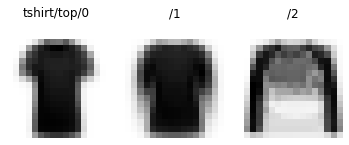

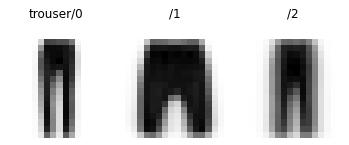

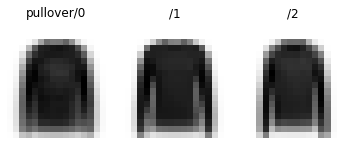

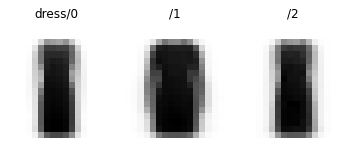

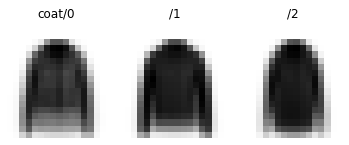

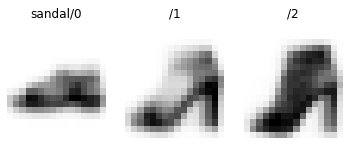

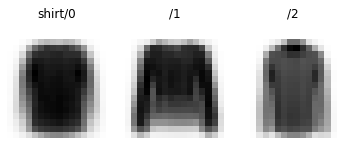

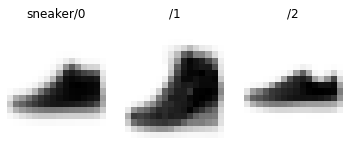

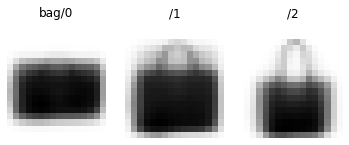

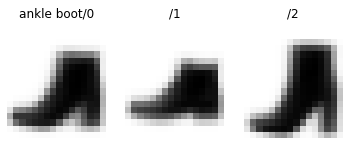

***Training a full-covariance GMM with K=5 components***
Label 0: 30 iterations, final MLL    399.889
Label 1: 12 iterations, final MLL    507.093
Label 2: 32 iterations, final MLL    421.536
Label 3: 24 iterations, final MLL    436.309
Label 4: 21 iterations, final MLL    417.482
Label 5: 13 iterations, final MLL    388.557
Label 6:  9 iterations, final MLL    391.333
Label 7: 10 iterations, final MLL    470.765
Label 8: 20 iterations, final MLL    335.052
Label 9: 24 iterations, final MLL    403.582
K=5: acc train 89.23, acc val 83.38


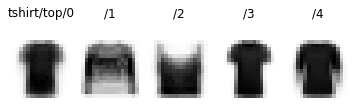

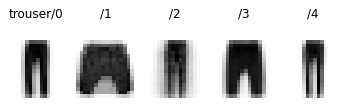

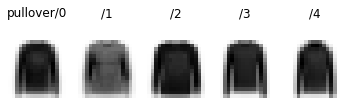

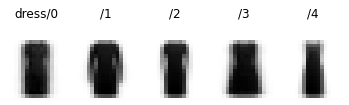

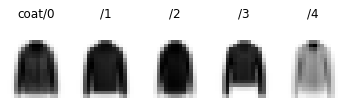

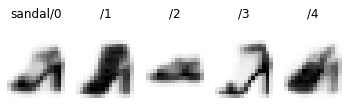

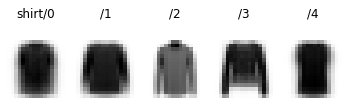

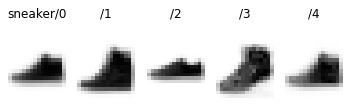

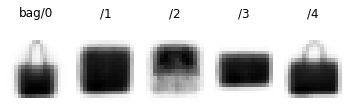

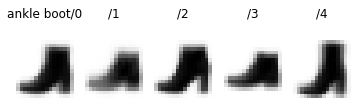

***Training a full-covariance GMM with K=7 components***
Label 0: 28 iterations, final MLL    409.865
Label 1: 38 iterations, final MLL    510.988
Label 2: 21 iterations, final MLL    428.454
Label 3: 37 iterations, final MLL    437.624
Label 4: 39 iterations, final MLL    423.122
Label 5: 14 iterations, final MLL    397.463
Label 6: 21 iterations, final MLL    396.549
Label 7:  7 iterations, final MLL    478.808
Label 8: 19 iterations, final MLL    346.903
Label 9: 13 iterations, final MLL    419.849
K=7: acc train 90.82, acc val 83.55


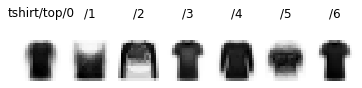

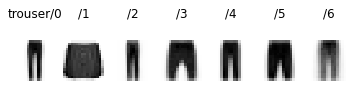

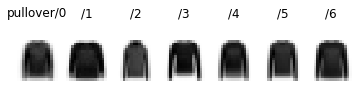

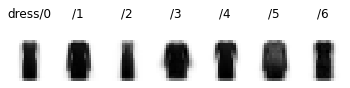

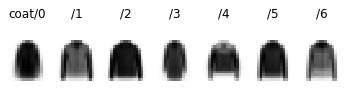

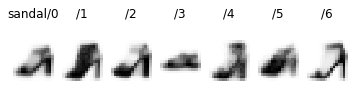

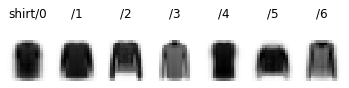

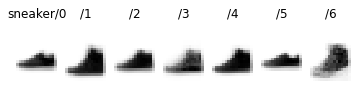

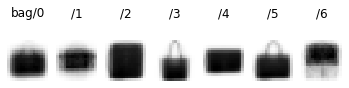

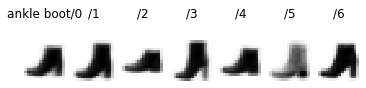

***Training a full-covariance GMM with K=9 components***
Label 0: 22 iterations, final MLL    414.990
Label 1: 15 iterations, final MLL    514.771
Label 2: 17 iterations, final MLL    422.975
Label 3: 13 iterations, final MLL    446.749
Label 4: 16 iterations, final MLL    433.093
Label 5: 17 iterations, final MLL    411.688
Label 6:  8 iterations, final MLL    404.590
Label 7: 19 iterations, final MLL    483.532
Label 8: 11 iterations, final MLL    354.668
Label 9: 17 iterations, final MLL    423.169
K=9: acc train 92.37, acc val 84.16


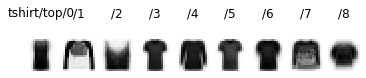

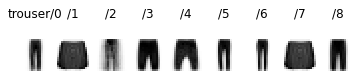

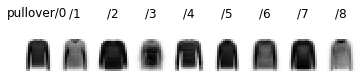

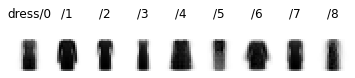

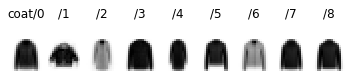

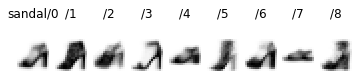

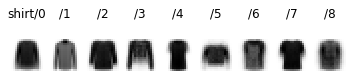

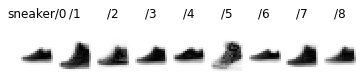

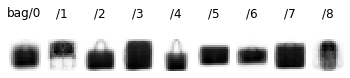

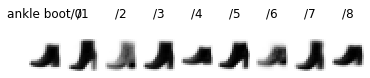

***Training a full-covariance GMM with K=11 components***
Label 0: 18 iterations, final MLL    424.171
Label 1: 29 iterations, final MLL    515.171
Label 2: 32 iterations, final MLL    435.232
Label 3: 34 iterations, final MLL    452.176
Label 4: 26 iterations, final MLL    433.312
Label 5: 17 iterations, final MLL    408.331
Label 6:  8 iterations, final MLL    405.576
Label 7: 25 iterations, final MLL    487.640
Label 8: 17 iterations, final MLL    361.095
Label 9: 12 iterations, final MLL    429.847
K=11: acc train 93.24, acc val 85.14


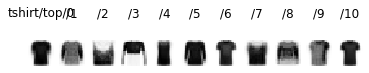

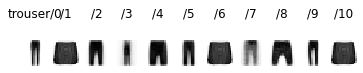

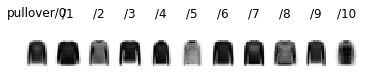

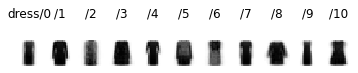

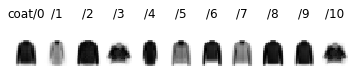

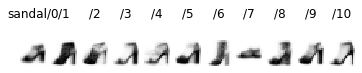

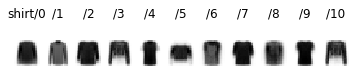

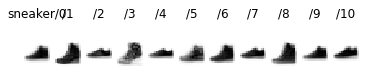

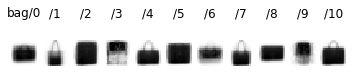

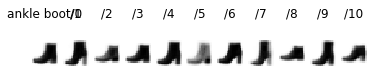

***Training a full-covariance GMM with K=13 components***
Label 0: 39 iterations, final MLL    422.579
Label 1: 15 iterations, final MLL    519.839
Label 2: 22 iterations, final MLL    440.384
Label 3: 24 iterations, final MLL    454.698
Label 4: 18 iterations, final MLL    438.525
Label 5: 11 iterations, final MLL    422.793
Label 6: 19 iterations, final MLL    416.406
Label 7: 14 iterations, final MLL    484.904
Label 8: 26 iterations, final MLL    371.504
Label 9: 15 iterations, final MLL    432.417
K=13: acc train 94.16, acc val 85.08


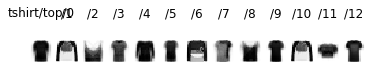

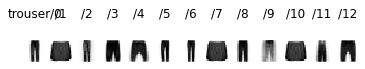

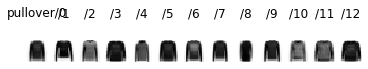

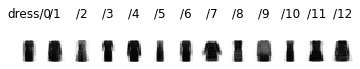

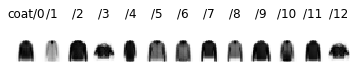

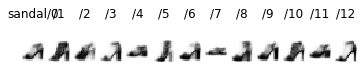

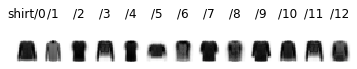

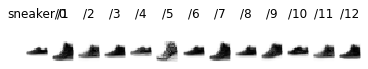

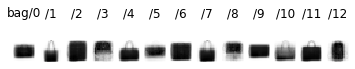

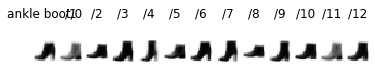

In [ ]:
set_seed(0)
smoothing = 0.001
#1, 3, 5, 7
for num_components in [1, 3, 5, 7, 9, 11, 13]:
  print('***Training a full-covariance GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=False)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))


  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()

## <font color=red>Question</font>
For GMMs with full covariance matrices, report
- $K=1$: train acc, val acc
- $K=3$: train acc, val acc

## <font color=red>Answer</font>
- $K=1$: the train acc is 76.28 and the val acc is 74.05
- $K=3$: the train acc is 85.96 and the val acc is 81.38


---

## <font color=red>Question</font>
Explore the model space with different settings: varying number of components across classes (required), covariance matrix restrictions (required), initialization of GMM, convergence criteria of training, etc
- Report the setting and val accuracy of your single **best model**.

- Describe (in detail) the **trend in accuracies** (train and val) across settings

- Describe (in detail) the **trend in visualized cluster** (displayed by the showMeans function) across settings

  

## <font color=red>Answer</font>
- Report the setting and val accuracy of your single **best model**.

  The best model had a training accuracy of 93.24 and validtion accuracy of 85.14. The settings for this model were that it was trained under a full-covariance GMM with K=11 components.


- Describe (in detail) the **trend in accuracies** (train and val) across settings

  The noticable trend in accuracies (both train and val) across the settings were that as you initially increase $K$, the accuracies tend to do better up until a certain point. There seems to be a certain threshold where incresing $K$ does not seem to impact the accuracies significantly enough -- especially since each increase in $K$ takes more computation time.

- Describe (in detail) the **trend in visualized cluster** (displayed by the showMeans function) across settings

  The noticable trend in visualized cluster across settings is that as you increase $K$ initially, the visualized clusters seem to improve greatly. But after a certain point increases to $K$ don't seem to impact the visual clusters that much -- meaning there isn't really too much improvement in the visual clusters after a certain $K$ threshold.

  